# Introduction

### Project initialization and setup

Importing all of the libraries that will be used. In the project.

In [71]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Connecting the DB to SQL

In [72]:
DB_PATH = "viewer_interactions.db"

try:
    conn = sqlite3.connect(DB_PATH)
    print("Connected successfully!")
except sqlite3.Error as e:
    print("Connection failed:", e)

Connected successfully!


In [73]:
# Display options
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

Listing all the tables

In [74]:
tables_query = """
               SELECT name
               FROM sqlite_master
               WHERE type='table'
               ORDER BY name; \
               """

tables_df = pd.read_sql_query(tables_query, conn)
print("Tables in the database:")
display(tables_df)

Tables in the database:


,name
0,data_dictionary
1,movie_statistics
2,movies
3,user_statistics
4,viewer_ratings


Creating a dictionary of type table_name -> DataFrame

In [75]:
table_names = tables_df["name"].tolist()

schemas = {}

for table in table_names:
    pragma_query = f"PRAGMA table_info({table});"
    schema_df = pd.read_sql_query(pragma_query, conn)
    schemas[table] = schema_df
    print(f"\nSchema for table '{table}':")
    display(schema_df)


Schema for table 'data_dictionary':


,cid,name,type,notnull,dflt_value,pk
0,0,table_name,TEXT,0,None,0
1,1,field_name,TEXT,0,None,0
2,2,data_type,TEXT,0,None,0
3,3,description,TEXT,0,None,0



Schema for table 'movie_statistics':


,cid,name,type,notnull,dflt_value,pk
0,0,movie_id,INTEGER,0,None,0
1,1,total_ratings,REAL,0,None,0
2,2,avg_rating,REAL,0,None,0
3,3,std_rating,REAL,0,None,0
4,4,min_rating,REAL,0,None,0
5,5,max_rating,REAL,0,None,0
6,6,unique_users,REAL,0,None,0
7,7,first_rating_date,TEXT,0,None,0
8,8,last_rating_date,TEXT,0,None,0
9,9,year_of_release,REAL,0,None,0



Schema for table 'movies':


,cid,name,type,notnull,dflt_value,pk
0,0,movie_id,INTEGER,0,None,0
1,1,year_of_release,REAL,0,None,0
2,2,title,TEXT,0,None,0



Schema for table 'user_statistics':


,cid,name,type,notnull,dflt_value,pk
0,0,customer_id,INTEGER,0,None,0
1,1,total_ratings,REAL,0,None,0
2,2,avg_rating,REAL,0,None,0
3,3,std_rating,REAL,0,None,0
4,4,min_rating,REAL,0,None,0
5,5,max_rating,REAL,0,None,0
6,6,unique_movies,REAL,0,None,0
7,7,first_rating_date,TEXT,0,None,0
8,8,last_rating_date,TEXT,0,None,0
9,9,activity_days,REAL,0,None,0



Schema for table 'viewer_ratings':


,cid,name,type,notnull,dflt_value,pk
0,0,movie_id,INTEGER,0,None,0
1,1,customer_id,INTEGER,0,None,0
2,2,rating,REAL,0,None,0
3,3,date,TEXT,0,None,0
4,4,anomalous_date,INTEGER,0,None,0


implementing dfs and importing data

In [76]:
dfs = {} # dictionary that maps the name of the table to the related data frame
# isnt it simpler if we just use universal dataframes for each dataset instead of having to worry about dictionaries

for t in table_names:
    df = pd.read_sql_query(f"SELECT * FROM {t};", conn)
    dfs[t] = df
    print(f"\nLoaded table '{t}' with shape {df.shape}")

# initializing the dataframes
movies_stats = dfs['movie_statistics']
movies = dfs['movies']
user_stats = dfs['user_statistics']
viewer_ratings = dfs['viewer_ratings']


Loaded table 'data_dictionary' with shape (31, 4)

Loaded table 'movie_statistics' with shape (16015, 11)

Loaded table 'movies' with shape (18008, 3)

Loaded table 'user_statistics' with shape (438780, 10)

Loaded table 'viewer_ratings' with shape (4025000, 5)


In [77]:
# Refreshes one or more global dataframes by passing the actual df objects.
def sync_dataframe(*dfs_to_refresh):
    global movies_stats, movies, user_stats, viewer_ratings

    for dataframe in dfs_to_refresh:
        if dataframe is movies_stats:
            movies_stats = dfs["movie_statistics"]
        elif dataframe is movies:
            movies = dfs["movies"]
        elif dataframe is user_stats:
            user_stats = dfs["user_statistics"]
        elif dataframe is viewer_ratings:
            viewer_ratings = dfs["viewer_ratings"]
        else:
            raise ValueError("Unknown dataframe passed!")

Searching function

In [78]:
# takes the name of the table, the name of the target key, and the value as inputs. Returns singular or multiple dataframes based on the request.

# can also search for null values if value is set to None

def search_by_parameter(table_name, key, value):
    df = dfs[table_name]

    if value is None:
        return df[df[key].isna()]

    return df[df[key] == value]

Giacomo thing

In [79]:
tables = pd.read_sql(
    "SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%';",
    conn
    )['name'].tolist()

print("=== DATA DICTIONARY ===\n")

for table in tables:
    print(f"Table: {table}")
    print("-" * (7 + len(table)))

    # Get actual column info from PRAGMA but filter to nice output
    schema = pd.read_sql(f"PRAGMA table_info('{table}')", conn)

    # Keep only real schema fields you want (remove cid, default, pk if desired)
    clean_schema = schema[['name', 'type', ]]

    print(clean_schema.to_string(index=False))
    print("\n")

=== DATA DICTIONARY ===

Table: viewer_ratings
---------------------
          name    type
      movie_id INTEGER
   customer_id INTEGER
        rating    REAL
          date    TEXT
anomalous_date INTEGER


Table: movies
-------------
           name    type
       movie_id INTEGER
year_of_release    REAL
          title    TEXT


Table: user_statistics
----------------------
             name    type
      customer_id INTEGER
    total_ratings    REAL
       avg_rating    REAL
       std_rating    REAL
       min_rating    REAL
       max_rating    REAL
    unique_movies    REAL
first_rating_date    TEXT
 last_rating_date    TEXT
    activity_days    REAL


Table: movie_statistics
-----------------------
             name    type
         movie_id INTEGER
    total_ratings    REAL
       avg_rating    REAL
       std_rating    REAL
       min_rating    REAL
       max_rating    REAL
     unique_users    REAL
first_rating_date    TEXT
 last_rating_date    TEXT
  year_of_release    RE

Counting all missing values, diagnostics purposes only

In [80]:
for name, df in dfs.items():
    print(f"\n{name} missing values (%):")
    missing_pct = df.isna().mean() * 100
    display(missing_pct.to_frame("missing_%"))


data_dictionary missing values (%):


,missing_%
table_name,0.0
field_name,0.0
data_type,0.0
description,0.0



movie_statistics missing values (%):


,missing_%
movie_id,0.000000
total_ratings,4.995317
avg_rating,4.995317
std_rating,57.246332
min_rating,4.995317
max_rating,4.995317
unique_users,4.995317
first_rating_date,0.000000
last_rating_date,0.000000
year_of_release,28.167343



movies missing values (%):


,missing_%
movie_id,0.000000
year_of_release,0.038872
title,0.000000



user_statistics missing values (%):


,missing_%
customer_id,0.000000
total_ratings,5.000000
avg_rating,5.000000
std_rating,24.215324
min_rating,5.000000
max_rating,5.000000
unique_movies,5.000000
first_rating_date,0.000000
last_rating_date,0.000000
activity_days,5.000000



viewer_ratings missing values (%):


,missing_%
movie_id,0.000000
customer_id,0.000000
rating,10.000000
date,0.000000
anomalous_date,99.969963


A function to calculate missing std. ratings of films

In [81]:
def compute_film_std(df):
    sync_dataframe(df)

    film_stats = (
        df.groupby('movie_id')['rating']
        .apply(list)
        .reset_index(name='ratings')
    )

    def manual_std(ratings):
        ratings = np.array(ratings)
        n = len(ratings)
        if n <= 1:
            return 0.0
        mean = ratings.mean()
        return np.sqrt(((ratings - mean) ** 2).mean())

    film_stats['std_rating'] = film_stats['ratings'].apply(manual_std)

    return film_stats[['movie_id', 'std_rating']]

# Compute std for all films
viewer_ratings = dfs['viewer_ratings']
film_std = compute_film_std(viewer_ratings)

# Load movies_statistics
movies_stats = dfs["movie_statistics"]

# Compute the old percentage before merging
old_null_pct = dfs["movie_statistics"]["std_rating"].isna().mean() * 100

# Merge new std values
movies_stats = movies_stats.merge(
    film_std,
    on="movie_id",
    how="left",
    suffixes=("", "_new")
)

# Replace old std_rating with the new one
movies_stats["std_rating"] = movies_stats["std_rating_new"]
movies_stats.drop(columns=["std_rating_new"], inplace=True)

# Save updated table
dfs["movie_statistics"] = movies_stats

# Compute new percentage ---
new_null_pct = movies_stats["std_rating"].isna().mean() * 100

# absolute improvement (percentage points)
improvement_abs = old_null_pct - new_null_pct

# relative improvement (how many percent of the original NaNs we removed)
improvement_rel = (improvement_abs / old_null_pct) * 100 if old_null_pct > 0 else 0

print(f"Missing values reduced from {old_null_pct:.2f}% to {new_null_pct:.2f}%.")
print(f"Absolute improvement: {improvement_abs:.2f}%")
print(f"Relative improvement: {improvement_rel:.2f}% better than before.")

Missing values reduced from 57.25% to 13.62%.
Absolute improvement: 43.63%
Relative improvement: 76.21% better than before.


In [82]:
#Figure out how to drop na values in general
movies_stats = dfs['movie_statistics']

print(f"Before cleaning: {len(movies_stats)} movies")
movies_stats = movies_stats.dropna(subset=['std_rating'])
dfs['movie_statistics'] = movies_stats
print(f"After removing single-rating movies: {len(movies_stats)} movies")

Before cleaning: 16015 movies
After removing single-rating movies: 13834 movies


Calculating the missing total_ratings of movies

In [83]:
sync_dataframe(movies_stats)

# Collecting all the movies with absent total_rating in a dictionary
missing_dict = {}

missing = search_by_parameter('movie_statistics', 'total_ratings', None)
missing_dict = {row.movie_id: 0 for row in missing.itertuples(index=False)}

# Iterating through viewer_ratings and manually counting the ratings for each film
for row in viewer_ratings.itertuples(index=False):
    movie_id = row.movie_id
    if movie_id in missing_dict:
        missing_dict[movie_id] += 1

# Update movie_stats
for row in movies_stats.itertuples(index=True):
    if row.movie_id in missing_dict:
        movies_stats.at[row.Index, "total_ratings"] = missing_dict[row.movie_id]

dfs["movie_statistics"] = movies_stats

Calculating Missing Averages

In [84]:
sync_dataframe(movies_stats, viewer_ratings)

# Finding movies with null avg_rating
missing_avg = search_by_parameter('movie_statistics', 'avg_rating', None)

# Creating a dict of type { movie_id : avg_rating }
# set 0 as base value for now, might change it later
missing_avg_dict = {row.movie_id: 0 for row in missing_avg.itertuples(index=False)}

# Storing the sum of all ratings for each movie
rating_sums = {movie_id: 0 for movie_id in missing_avg_dict}

# Iterating through viewer ratings and adding to sum if movie_id matches
for row in viewer_ratings.itertuples(index=False):
    movie_id = row.movie_id
    rating = row.rating

    if movie_id in missing_avg_dict:
        rating_sums[movie_id] += rating

for row in movies_stats.itertuples():
    movie_id = row.movie_id

    if movie_id in rating_sums:
        total = row.total_ratings # I'm assuming that my calculations of total_ratings per movie is correct ang i got rid of                            all null values

        # IF FORE SOME MAGICAL REASON THERE IS STILL A NULL THEN IGNORE
        if pd.isna(total) or total == 0:
            avg = 0
        else:
            avg = rating_sums[movie_id] / total

        movies_stats.at[row.Index, "avg_rating"] = avg

Calculating the missing min and max ratings for movies

In [85]:
sync_dataframe(movies_stats)

# Find movies with missing min_rating and max_rating using your function
missing_min = search_by_parameter('movie_statistics', 'min_rating', None)
missing_max = search_by_parameter('movie_statistics', 'max_rating', None)

# Combine them as some movies may be in both
missing_ids = set(missing_min["movie_id"]) | set(missing_max["movie_id"])

# Take only ratings for the movies we care
relevant_ratings = viewer_ratings[viewer_ratings["movie_id"].isin(missing_ids)]

# Building a nested dict {movie_id : {"min": ..., "max": ...}}
min_max_dict = {}

for row in relevant_ratings.itertuples(index=False):
    movie_id = row.movie_id
    rating = row.rating

    if movie_id not in min_max_dict:
        min_max_dict[movie_id] = {"min": rating, "max": rating}
    else:
        if rating < min_max_dict[movie_id]["min"]:
            min_max_dict[movie_id]["min"] = rating
        if rating > min_max_dict[movie_id]["max"]:
            min_max_dict[movie_id]["max"] = rating

# Update movie_statistics
for row in movies_stats.itertuples(index=True):
    movie_id = row.movie_id

    if movie_id in min_max_dict:
        if pd.isna(row.min_rating):
            movies_stats.at[row.Index, "min_rating"] = min_max_dict[movie_id]["min"]
        if pd.isna(row.max_rating):
            movies_stats.at[row.Index, "max_rating"] = min_max_dict[movie_id]["max"]

dfs["movie_statistics"] = movies_stats

Finding missing unique users

In [86]:
sync_dataframe(movies_stats)

missing_unique = search_by_parameter('movie_statistics', 'unique_users', None)

# creating my favorite movie set
missing_movie_ids = {row.movie_id for row in missing_unique.itertuples(index=False)}

# creating a dict movie_id: customer_id
unique_users_dict = {movie_id: set() for movie_id in missing_movie_ids}

# Gathering unique users
for row in viewer_ratings.itertuples(index=False):
    movie_id = row.movie_id

    # as always im getting only those movies which have null for unique users
    if movie_id in unique_users_dict:
        unique_users_dict[movie_id].add(row.customer_id)

# Counting unique users
updated = 0
for movie_id, users in unique_users_dict.items():
    count = len(users)  # unique users count

    movies_stats.loc[
        movies_stats["movie_id"] == movie_id,
        "unique_users"
    ] = count

    updated += 1

# just in case if a movie has 0 ratings im setting unique users to 0
movies_stats["unique_users"] = movies_stats["unique_users"].fillna(0).astype(int)

# Updating
dfs["movie_statistics"] = movies_stats

Checking for any duplicate movie ids and removing them from all datasets to clean the data.

Merging the Movies and movie statis filling in missing values on either dataset and converting all of the dates to type DateTime as well as all counts and years to integers.
This is in order to clean our movie data before merging it with our user data to fill in any recoverable missing values.
Rows with missing values will be dropped.

In [87]:
movies = dfs['movies'].copy() # does this overwrite the movies we have right now? maybe call it something else.
movie_stats = dfs['movie_statistics'].copy()
viewer_ratings = dfs['viewer_ratings'].copy()

bad_ids_movies = movies.loc[movies['movie_id'].duplicated(keep=False), 'movie_id'].unique().tolist()
bad_ids_stats = movie_stats.loc[movie_stats['movie_id'].duplicated(keep=False), 'movie_id'].unique().tolist()
bad_ids = list(set(bad_ids_movies + bad_ids_stats))
print('bad movie ids to remove: ', bad_ids)

viewer_ratings = viewer_ratings[~viewer_ratings['movie_id'].isin(bad_ids)]
movies = movies[~movies['movie_id'].isin(bad_ids)]
movie_stats = movie_stats[~movie_stats['movie_id'].isin(bad_ids)]

movies['year_of_release'] = (pd.to_numeric(movies['year_of_release'], errors='coerce').astype('Int64'))
movie_stats['total_ratings'] = (pd.to_numeric(movie_stats['total_ratings'], errors='coerce').astype('Int64'))
movie_stats['unique_users'] = (pd.to_numeric(movie_stats['unique_users'], errors='coerce').astype('Int64'))
movie_stats['year_of_release'] = (pd.to_numeric(movie_stats['year_of_release'], errors='coerce').astype('Int64'))

movie_stats['first_rating_date'] = pd.to_datetime(movie_stats['first_rating_date'], errors='coerce')
movie_stats['last_rating_date'] = pd.to_datetime(movie_stats['last_rating_date'], errors='coerce')

# this will automatically remove rows with missing data
movie_full = movies.merge(movie_stats, on='movie_id', how='inner', suffixes=('_movies', '_stats'))

movie_full['title'] = movie_full['title_movies'].combine_first(movie_full['title_stats'])
movie_full['year_of_release'] = movie_full['year_of_release_movies'].combine_first(movie_full['year_of_release_stats'])

movie_full = movie_full.drop(columns=['title_movies', 'title_stats', 'year_of_release_movies', 'year_of_release_stats'])

dfs['movies'] = movies
dfs['movie_statistics'] = movie_stats
dfs['viewer_ratings'] = viewer_ratings
dfs['movie_full'] = movie_full

bad movie ids to remove:  [21756, 19549]


In [88]:
print("movies dtypes:")
print(movies.dtypes)

print("\nmovie_stats dtypes:")
print(movie_stats.dtypes)

print("\nmovie_full dtypes:")
print(movie_full.dtypes)

movies dtypes:
movie_id            int64
year_of_release     Int64
title              object
dtype: object

movie_stats dtypes:
movie_id                      int64
total_ratings                 Int64
avg_rating                  float64
std_rating                  float64
min_rating                  float64
max_rating                  float64
unique_users                  Int64
first_rating_date    datetime64[ns]
last_rating_date     datetime64[ns]
year_of_release               Int64
title                        object
dtype: object

movie_full dtypes:
movie_id                      int64
total_ratings                 Int64
avg_rating                  float64
std_rating                  float64
min_rating                  float64
max_rating                  float64
unique_users                  Int64
first_rating_date    datetime64[ns]
last_rating_date     datetime64[ns]
title                        object
year_of_release               Int64
dtype: object


- Converts the date parameter in viewer_ratings to datetime.
- Merges viewer_ratings, movies, movie_statistics and user_statistics into one dataset as merged_data.

In [89]:
user_stats = dfs['user_statistics'].copy()
viewer_ratings = dfs['viewer_ratings'].copy()
movie_full = dfs['movie_full'].copy()

viewer_ratings['date'] = pd.to_datetime(viewer_ratings['date'], errors = 'coerce')
user_stats['first_rating_date'] = pd.to_datetime(user_stats['first_rating_date'], errors = 'coerce')
user_stats['last_rating_date'] = pd.to_datetime(user_stats['last_rating_date'], errors = 'coerce')

user_stats['total_ratings'] = (pd.to_numeric(user_stats['total_ratings'], errors='coerce').astype('Int64'))
user_stats['unique_movies'] = (pd.to_numeric(user_stats['unique_movies'], errors='coerce').astype('Int64'))
user_stats['activity_days'] = (pd.to_numeric(user_stats['activity_days'], errors='coerce').astype('Int64'))


# create user and movie specific columns
movie_full = movie_full.rename(columns={
    'total_ratings':     'movie_total_ratings',
    'avg_rating':        'movie_avg_rating',
    'std_rating':        'movie_std_rating',
    'min_rating':        'movie_min_rating',
    'max_rating':        'movie_max_rating',
    'first_rating_date': 'movie_first_rating_date',
    'last_rating_date':  'movie_last_rating_date'
})


user_stats = user_stats.rename(columns={
    'total_ratings':     'user_total_ratings',
    'avg_rating':        'user_avg_rating',
    'std_rating':        'user_std_rating',
    'min_rating':        'user_min_rating',
    'max_rating':        'user_max_rating',
    'first_rating_date': 'user_first_rating_date',
    'last_rating_date':  'user_last_rating_date'
})

# drop anomalous date for user stats
if 'anomalous_date' in viewer_ratings.columns:
    viewer_ratings = viewer_ratings.drop(columns=['anomalous_date'])

viewer_ratings.dtypes

merged_data = viewer_ratings.merge(movies, on = 'movie_id', how = 'left')
merged_data = merged_data.merge(user_stats, on = 'customer_id', how = 'left')
merged_data = merged_data.merge(movie_stats, on = 'movie_id', how = 'left')
# avg rating standard rating mean rating
'''
want to merge
- title
- year of release
want to keep independent
- avg rating
- std rating
- min rating
- max rating
- first rating date
- last rating date
'''

print("Total columns:", len(merged_data.columns))
list(merged_data.columns)

Total columns: 25


['movie_id',
 'customer_id',
 'rating',
 'date',
 'year_of_release_x',
 'title_x',
 'user_total_ratings',
 'user_avg_rating',
 'user_std_rating',
 'user_min_rating',
 'user_max_rating',
 'unique_movies',
 'user_first_rating_date',
 'user_last_rating_date',
 'activity_days',
 'total_ratings',
 'avg_rating',
 'std_rating',
 'min_rating',
 'max_rating',
 'unique_users',
 'first_rating_date',
 'last_rating_date',
 'year_of_release_y',
 'title_y']

Giacomo

Ryder

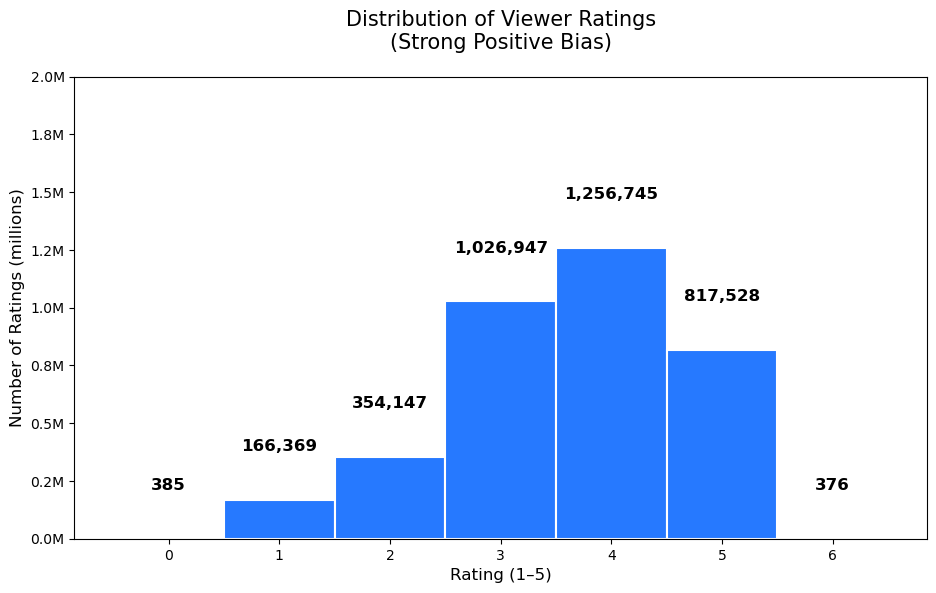

In [90]:
import seaborn as sns


# Markdown cell above
"""
### Global Rating Distribution

There is a clear over positive bias. This can be due to the fact that this was done on a streaming platform where users are more likely to rate higher
"""

plt.figure(figsize=(11, 6)) # made it this size for a better fit in the read me
ax = sns.histplot(
    data=dfs['viewer_ratings'],
    x='rating',
    bins=5,
    discrete=True, #tells seaborn to treat x as integer values
    color="#0062ff",
    edgecolor='white',
    alpha=0.85,  #transparency
    linewidth=1.5
)

# Add exact counts on top of each bar
for rect in ax.patches:
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width()/2., 
        height + 200_000,                    # a bit above the bar
        f'{int(height):,}',                  # adds commas: 12,345,678
        ha='center', va='bottom', fontsize=12, fontweight='bold'
    )

# Clean y-axis
plt.ylabel('Number of Ratings (millions)', fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

plt.title('Distribution of Viewer Ratings\n(Strong Positive Bias)', 
          fontsize=15, pad=20)
plt.xlabel('Rating (1–5)', fontsize=12)
plt.xticks(range(0, 7))
plt.ylim(0, 2_000_000)
plt.show()

In [91]:
#test code block to commit